
# Intro To Deep Learning
## Introduction
We will be training a convolutional neural network on the CIFAR10 dataset. This homework will guide you through loading and preprocessing data, and training and evaluating a model.

We will be building the all-cnn-c model described in the research paper attached here. The model will perform convolutions on the input images to predict one of 10 image classes.

## Dataset
The dataset can be loaded using numpy. The dataset contains 32x32 RGB images. Each file in the dataset contains 10,000 images in a 1000x3072 array. If you reshape the data to 10000x3x32x32, the dimensions are (images, channels, rows, columns). The pixel values are 0-255 unsigned bytes.

Download the data from https://www.cs.toronto.edu/~kriz/cifar.html

## Preprocessing (40 points)
The first part of this assignment is to write functions to load and preprocess the CIFAR10 data.

For further pre-processing of the data create functions for

<li>sample_zero_mean: subtract sample-wise mean from data
<li> gcn: global contrast normalization (divide by sample-wise standard deviation)
<li> feature_zero_mean: subtract feature-wise mean from data
<li> zca: whiten data using ZCA transformation
<li> cifar_10_preprocess: chain all of the previous functions to process a dataset

## Building an All-Convolutional Neural Network (30 points)
Build an All-Convolutional Neural Network (ALL-CNN-C) as described in the referenced paper using the hyperparameters described therein. Implement the following functions:

<li> flatten_module: create a custom module that reshapes data as described in the template
<li> all_cnn_module: create a sequential module containing all 23 layers described in the All-CNN-C Model and the template file


You will create a model that takes as input (samples, 3, 32,32) and produces outputs (samples, 10) that are the unnormalized pre-softmax activations.

## Training the Model (25 points)
Now that you have preprocessed the data and correctly built a model, it is time to train. Parameters described in the paper:

stochastic gradient descent with momentum of 0:9 L2 regularization of 0.001 on all weights

Train your model You should see 70% accuracy within minutes. This vanilla model (no augmentation, smoothing, etc.) should achieve around 90% accuracy.

Write your predictions on the test set in order. You will receive credit for reaching at least 70% accuracy.

# CIFAR 10 Convolutional Neural Network using PyTorch


### Testing for GPU


In [15]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()      # checking for GPU

if not train_on_gpu:
  print('CUDA is not available . Train on CPU . . . . ')
else:
  print('CUDA is available! Training on GPU . . . . ')

CUDA is available! Training on GPU . . . . 


## TORCHVISION.DATASETS

All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented. Hence, they can all be passed to a torch.utils.data.DataLoader which can load multiple samples in parallel using torch.multiprocessing workers.


## TORCHVISION.TRANSFORMS

Transforms are common image transformations. They can be chained together using Compose. Additionally, there is the torchvision.transforms.functional module. Functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).

All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input. Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width. Batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch. Deterministic or random transformations applied on the batch of Tensor Images identically transform all the images of the batch.



In [16]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Visualizing some of our Training Data

In [17]:

import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

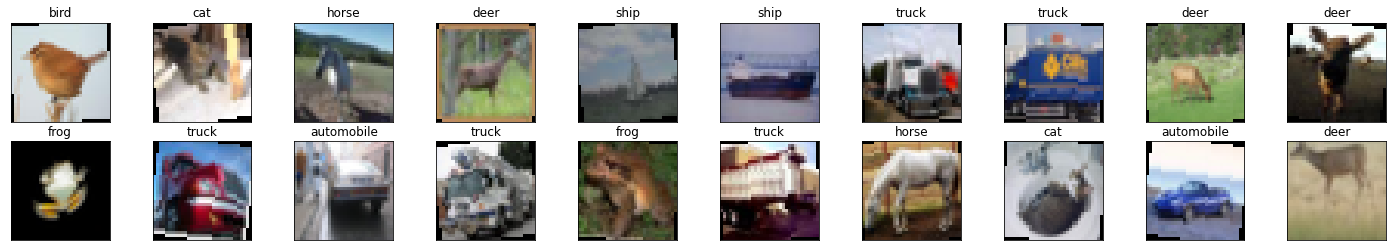

In [18]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Viewing an Image in More detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

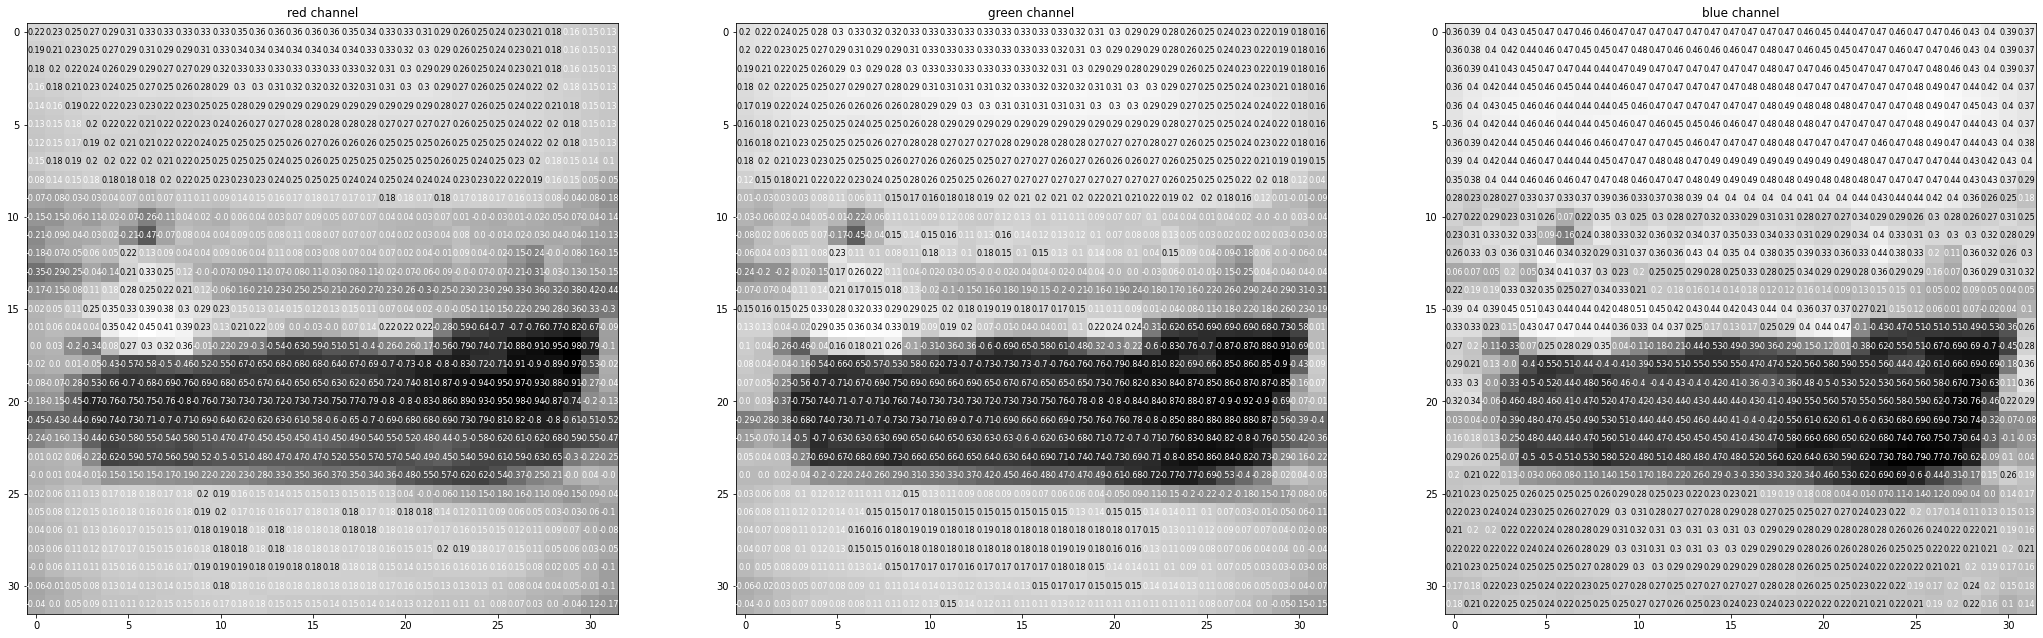

In [19]:
rgb_img = np.squeeze(images[5])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## The Network Architecture


<li>Convolutional layers, which can be thought of as stack of filtered images.
<li>Maxpooling layers, which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
<li>The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.


In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## Loss Function and Optimizer



In [21]:

import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training the Convolutional Neural Network

In [22]:
n_epochs = 30      #number of epochs to train

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.663681 	Validation Loss: 0.363014
Validation loss decreased (inf --> 0.363014).  Saving model ...
Epoch: 2 	Training Loss: 1.344089 	Validation Loss: 0.303061
Validation loss decreased (0.363014 --> 0.303061).  Saving model ...
Epoch: 3 	Training Loss: 1.193024 	Validation Loss: 0.279433
Validation loss decreased (0.303061 --> 0.279433).  Saving model ...
Epoch: 4 	Training Loss: 1.103385 	Validation Loss: 0.256996
Validation loss decreased (0.279433 --> 0.256996).  Saving model ...
Epoch: 5 	Training Loss: 1.039612 	Validation Loss: 0.242066
Validation loss decreased (0.256996 --> 0.242066).  Saving model ...
Epoch: 6 	Training Loss: 0.988037 	Validation Loss: 0.229826
Validation loss decreased (0.242066 --> 0.229826).  Saving model ...
Epoch: 7 	Training Loss: 0.945929 	Validation Loss: 0.220821
Validation loss decreased (0.229826 --> 0.220821).  Saving model ...
Epoch: 8 	Training Loss: 0.900369 	Validation Loss: 0.214950
Validation loss decreased (0.22082

In [23]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

In [24]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.702737

Test Accuracy of airplane: 78% (780/1000)
Test Accuracy of automobile: 81% (819/1000)
Test Accuracy of  bird: 65% (654/1000)
Test Accuracy of   cat: 53% (539/1000)
Test Accuracy of  deer: 72% (727/1000)
Test Accuracy of   dog: 70% (701/1000)
Test Accuracy of  frog: 83% (837/1000)
Test Accuracy of horse: 82% (828/1000)
Test Accuracy of  ship: 89% (892/1000)
Test Accuracy of truck: 82% (827/1000)

Test Accuracy (Overall): 76% (7604/10000)


We got overall test accuracy of 76%